## Extract one OC with the DBSCAN parameters

In [1]:
using PyCall
using Statistics , StatsBase
using  DataFrames, Printf

import PyPlot
sns= pyimport("seaborn")

## directory
rootdir = ENV["GAIA_ROOT"]
wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
plotdir = "$rootdir/products/testfull2"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering


cd(wdir)

In [2]:
function _get_OC(df , dfcart, labels , labelmax)
    ra= df.raw[1, labels[labelmax]]
    dec= df.raw[2,labels[labelmax]]
    l= df.data[1, labels[labelmax]]
    b= df.data[2,labels[labelmax]]
    d= df.data[3,labels[labelmax]]
    pmra= df.raw[6, labels[labelmax]]
    pmdec= df.raw[7, labels[labelmax]]
    X= dfcart.data[1, labels[labelmax]]
    Y= dfcart.data[2, labels[labelmax]]
    Z= dfcart.data[3, labels[labelmax]]
    vl= df.data[4,labels[labelmax]]
    vb= df.data[5,labels[labelmax]]
    vrad= df.raw[13,labels[labelmax]]
    gbar= df.raw[10,labels[labelmax]]
    rp= df.raw[11,labels[labelmax]]
    bp= df.raw[12,labels[labelmax]]
    ag= df.raw[14,labels[labelmax]]

    oc= DataFrame(ra=ra,dec=dec,l=l,b=b, distance=d,pmra=pmra, pmdec=pmdec, X=X,Y=Y,Z=Z,vl=vl,vb=vb,vrad=vrad,gbar=gbar,rp=rp,bp=bp, ag=ag)

    return(oc)
end

function _getdata(voname, wghtblck)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false)
    return(df, dfcart , dfcartnorm)
end

_getdata (generic function with 1 method)

In [3]:
## return the "best cluster"

function _find_cluster_label(labels, df::GaiaClustering.Df, dfcart::GaiaClustering.Df ,
    aperture2d = 1.5, maxaperture2d = 15, aperturev = 3.0, maxaperturev = 20, nboot = 30)
    
    ### metrics of the clusters
    q2d = metric2(dfcart, labels, "spatial2d" , aperture2d, maxaperture2d, nboot)
    q3d = metric2(dfcart, labels, "spatial3d" , aperture2d, maxaperture2d, nboot)     #### Added
    qv  = metric2(dfcart, labels, "velocity" , aperturev, maxaperturev, nboot)
    qp, qa = metric2(dfcart, labels, "HRD" )

    nlab = []
    for ilab in labels
        push!(nlab,length(ilab))
    end
    
    #### metric for the number of stars in the cluster
    qn = []
    for nl in nlab
        push!(qn,log10(nl))
    end
    
    qc= []
    for i in 1:length(nlab)
        k1 = q2d[i][1]
        k1bis = q3d[i][1]
        k2 = qv[i][1]
        k3 = qa[i][1]
        k4 = qn[i]
        ############### Composite metric ###
        qq = (2k1 + k1bis + 3k2 + k3 + k4) / 8.0
        # qq = (3k1 + k1bis + 3k2 + k4) / 8.0
        ###############
        push!(qc,qq)
    end
    
    println(qc)
    bestlabel= findmax(qc)[2]
    println("best label $bestlabel")
    
    return(bestlabel, nlab[bestlabel])
end

_find_cluster_label (generic function with 6 methods)

In [4]:
votname= "test.vot"

w3d=  3.39396572939143
wvel=  6.74019078528277
whrd=  2.4729797724399

wght= [w3d, wvel, whrd]
df , dfcart , dfcartnorm = _getdata(votname, wght)

eps     =  3.8928354667570
min_cl  = 19
min_nei = 8


labels = clusters(dfcartnorm.data ,eps  , 20, min_nei, min_cl)
labelbest, nstars= _find_cluster_label(labels, df, dfcart)
# labelmax , nmax = find_cluster_label(labels)

oc= _get_OC(df , dfcart, labels , labelbest)

## Votable test.vot read
## Filtering done ...
## Stars selected: 36759
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.2830622896905794, 0.2830622896905794, 0.2830622896905794, 0.5621429291731795, 0.5621429291731795, 0.2062505554146665, 0.2062505554146665, 0.2062505554146665]
##
Any[0.7747193779208152, 1.772110577286111, 0.7347125588076953, 0.6515649223093667, 1.4185319533375191, 0.8331550159305597, 0.5395345904518696, 1.3797033590371623, 0.5460950014537009, 0.7185599654105466, 0.890962087224227, 0.5102691069381236, 0.6900267233558178, 0.9479286885037332, 0.8283138708922029, 0.6337710003655774, 0.6371402229152934, 0.9474606119104885, 0.6580512334693032, 0.629262255986294, 0.8886790083022049, 0.5433243674031545, 0.5854816360384705, 0.7439519739463807, 0.6975895756416494, 0.7461255216868015, 0.42006403514456925, 0.5180197538573088, 0.5966401228545084, 0.7117076882378282, 0.6798302681439461, 0.8143884374

,ra,dec,l,b,distance,pmra,pmdec,X,Y
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,67.8586,43.8876,159.171,-2.96923,1009.14,2.156,-1.38176,1009.14,-1.28793
2,67.4918,43.84,159.024,-3.19444,1019.3,2.45114,-1.48925,1019.29,-3.91141
3,67.9757,43.838,159.265,-2.94143,982.89,1.93774,-1.49414,982.889,0.357296
4,67.8332,43.8107,159.214,-3.03516,1056.74,1.69844,-1.67796,1056.74,-0.544018
5,67.9438,43.8452,159.244,-2.95333,1038.4,2.35244,-1.01703,1038.4,-0.00192244
6,67.4429,43.6935,159.106,-3.32079,968.529,2.53875,-1.03882,968.51,-2.32419
7,68.7128,43.7998,159.654,-2.57694,955.217,2.28782,-1.31406,955.168,6.84366
8,68.2594,44.1477,159.177,-2.58107,1005.28,2.18971,-1.28486,1005.25,-1.17476
9,67.8487,43.8032,159.227,-3.03218,956.196,3.09417,-1.86125,956.196,-0.271914


In [5]:
## plot_cluster

function _plot_oc(df)
    PyPlot.plt.figure(figsize=(13.0,12.0))

    PyPlot.plt.subplot(3, 3, 1 , xlim = [-10,10] , ylim = [-10,10])
    PyPlot.plt.scatter(df.Y .- mean(df.Y), df.Z .- mean(df.Z) , s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 2 , ylim = [-20,20])
    PyPlot.plt.scatter(df.X, df.Z .- mean(df.Z)  , s = 1.0 )
    PyPlot.plt.xlabel("X (pc)")
    PyPlot.plt.ylabel("Z (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 4 , xlim = [-20,20])
    PyPlot.plt.scatter(df.Y .- mean(df.Y) , df.X, s = 1.0 )
    PyPlot.plt.xlabel("Y (pc)")
    PyPlot.plt.ylabel("X (pc)")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 3 )
    PyPlot.plt.scatter(df.X, df.vrad , s = 1.0 )
    PyPlot.plt.xlabel("X(pc)")
    PyPlot.plt.ylabel("Vrad (km/s)")
    PyPlot.plt.grid(true)    
        
    PyPlot.plt.subplot(3, 3, 5)
    PyPlot.plt.axis("off")
    ## text to display
    text =[]
    txt = @sprintf("N stars: %3d",length(df.X)) ; push!(text,txt)
    txt = @sprintf("Distance: %3.1f (pc) +/- %3.1f",median(df.distance), std(df.distance)) ; push!(text,txt)
    txt = @sprintf("l: %3.3f (degree)",median(df.l)) ; push!(text,txt)
    txt = @sprintf("b: %3.3f (degree)",median(df.b)) ; push!(text,txt)  
    txt = @sprintf("Vl: %3.2f (km/s)",median(df.vl)) ; push!(text,txt) 
    txt = @sprintf("Vb: %3.2f (km/s)",median(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr: %3.2f (km/s, no masking)",median(df.vrad)) ; push!(text,txt)
    txt = @sprintf("X disp.: %3.2f (pc)", std(df.X)) ; push!(text,txt)
    txt = @sprintf("Y disp.: %3.2f (pc)", std(df.Y)) ; push!(text,txt)  
    txt = @sprintf("Z disp.: %3.2f (pc)", std(df.Z)) ; push!(text,txt)
    txt = @sprintf("Vl disp.: %3.2f (km/s) ", std(df.vl)) ; push!(text,txt)
    txt = @sprintf("Vb disp.: %3.2f (km/s)", std(df.vb)) ; push!(text,txt)
    txt = @sprintf("Vr disp.: %3.2f (km/s)", std(df.vrad)) ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt.subplot(3, 3, 7 )
    PyPlot.plt.axis("on")    
    PyPlot.plt.scatter(df.gbar-df.rp, -df.gbar , s = 1.0 )
    PyPlot.plt.xlabel("G-Rp")
    PyPlot.plt.ylabel("G")
    PyPlot.plt.grid(true)
    
    PyPlot.plt.subplot(3, 3, 8 )
    PyPlot.plt.scatter(df.vl, df.vb , s = 1.0 )
    PyPlot.plt.xlabel("Vl (km/s)")
    PyPlot.plt.ylabel("Vb (km/s)")
    PyPlot.plt.grid(true)
end

_plot_oc (generic function with 1 method)

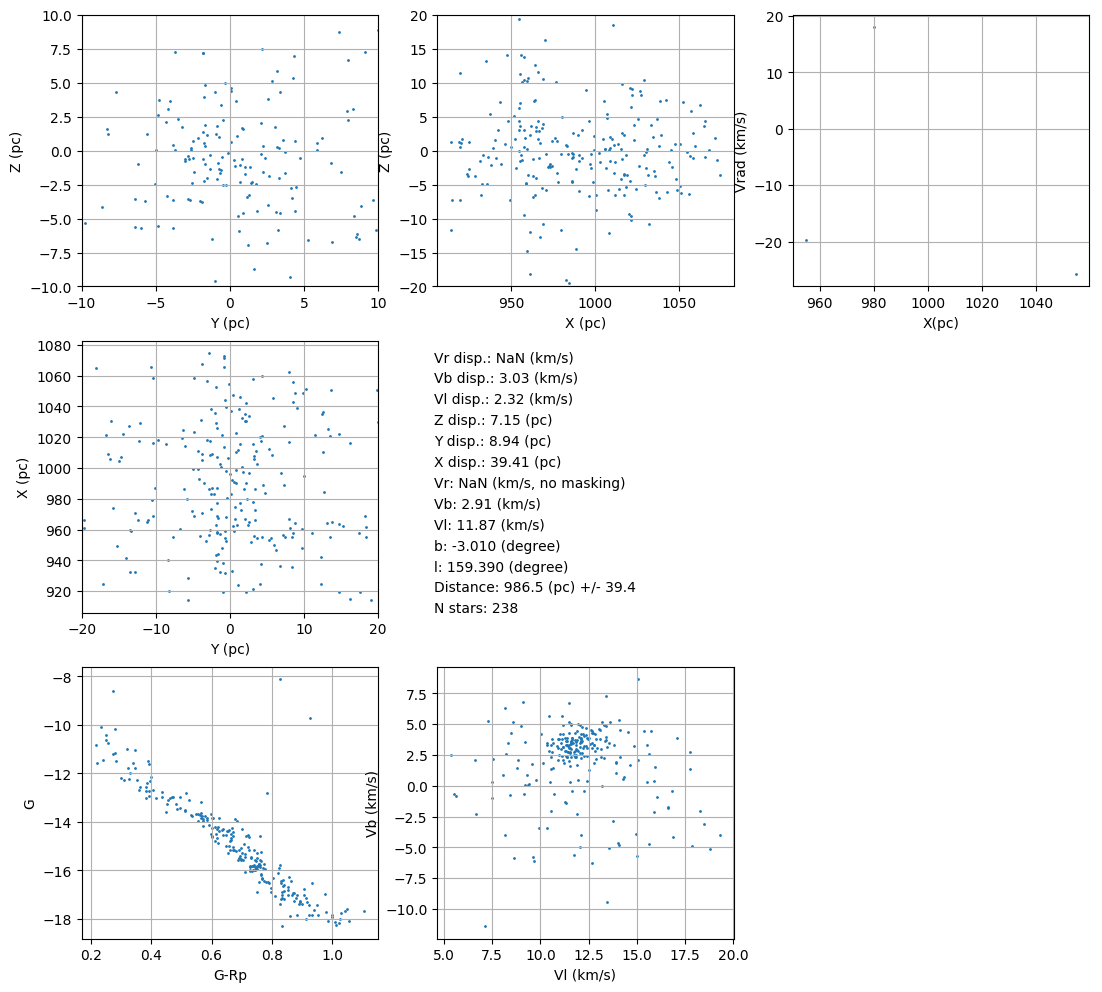

In [6]:
_plot_oc(oc)